--------------------------

# Snapping point to segments

In [1]:
import os
last_modified = None
if os.name == "posix":
    last_modified = !stat -f\
                    "# This notebook was last updated: %Sm"\
                     Snapping_Demonstration.ipynb
elif os.name == "nt":
    last_modified = !for %a in (Snapping_Demonstration.ipynb)\
                    do echo # This notebook was last updated: %~ta
    
if last_modified:
    get_ipython().set_next_input(last_modified[-1])

In [ ]:
# This notebook was last updated: Nov 24 15:50:51 2018

-------------------------------

In [9]:
import numpy as np
from libpysal import examples
import geopandas as gpd
import spaghetti as spgh
from shapely.geometry import Point

%matplotlib inline

__author__ = 'James Gaboardi <jgaboardi@gmail.com>'

-----------------------------------------

## Segments

In [10]:
streets = examples.get_path("streets.shp")
streets = gpd.read_file(streets)

## Points

In [11]:
crimes = examples.get_path("crimes.shp")
crimes = gpd.read_file(crimes)
np.random.seed(1)
crimes['geometry'] = np.random.permutation(crimes['geometry'])

## Initial plot

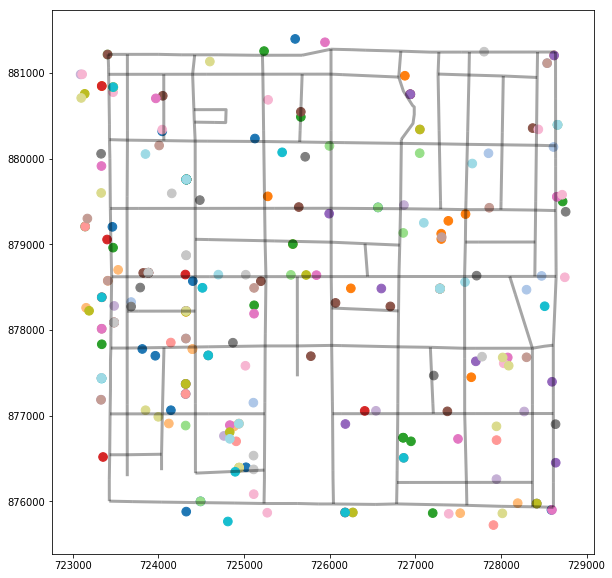

In [12]:
base = streets.plot(figsize=(10,10), color='k', alpha=.35, linewidth=3)
crimes.plot(ax=base, cmap='tab20', markersize=75)

# Network

In [13]:
net = spgh.Network(in_data=streets)

## Snap point onto nearest segments

In [14]:
net.snapobservations(crimes, 'crimes')
#
#snapped = net.pointpatterns['crimes'].snapped_coordinates

## Create `geopandas.GeoDataFrame` objects of snapped points

In [15]:
snapped_gdf = spgh.element_as_gdf(net, pp_name='crimes', snapped=True)

## Original point coordinates, snapped point coordinates

In [16]:
original = net.pointpatterns['crimes'].points
print(original[0]['coordinates'], snapped_gdf.geometry[0].coords[:])

(726942.0000000028, 880750.9999999988) [(726901.5389320733, 880725.212354287)]


## Snapped points plot

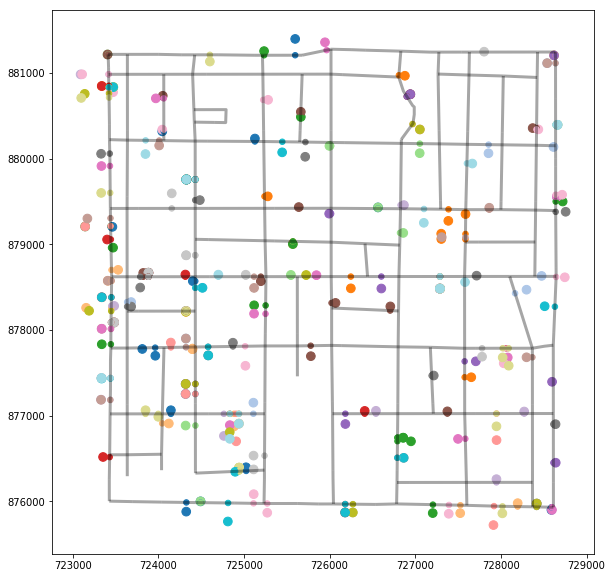

In [17]:
base = streets.plot(figsize=(10,10), color='k', alpha=.35, linewidth=3)
crimes.plot(ax=base, cmap='tab20', markersize=75)
snapped_gdf.plot(ax=base, cmap='tab20', markersize=30)

---------------------------------------------